# mount drive

In [50]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# import packages
import datetime
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

### 018-1
004の時間をone-hot-encoding

In [52]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [53]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 時系列の特徴量を追加
data["time"] = pd.to_datetime(data["time"])
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["weekday"] = data["time"].dt.weekday

In [54]:
# 学習データ全体から座標，方角，曜日，時間，分ごとの平均値を計算
col = ["x", "y", "direction", "hour", "minute", "weekday"]
minute_mean = data.iloc[:len(train)].groupby(col).mean()
minute_mean.columns = ["minute_mean"]
data = data.merge(minute_mean, how="left", left_on=col, right_index=True)

In [55]:
# direction, hourをone-hot-encoding
data = pd.get_dummies(data, columns=["direction", "hour"])

# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [56]:
# 特徴量と目的変数に分ける
X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)

In [57]:
direction_col = [col for col in X_train.columns if "direction" in col]
categorical_features = ["x", "y"] + direction_col

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                           categorical_feature=categorical_features)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.72598	valid_1's l1: 9.8088
[20]	training's l1: 7.63265	valid_1's l1: 7.71631
[30]	training's l1: 6.63285	valid_1's l1: 6.71529
[40]	training's l1: 6.18484	valid_1's l1: 6.27256
[50]	training's l1: 5.98925	valid_1's l1: 6.08468
[60]	training's l1: 5.90325	valid_1's l1: 6.0069
[70]	training's l1: 5.86072	valid_1's l1: 5.97203
[80]	training's l1: 5.83561	valid_1's l1: 5.95757
[90]	training's l1: 5.81868	valid_1's l1: 5.95025
[100]	training's l1: 5.80437	valid_1's l1: 5.94778
Early stopping, best iteration is:
[99]	training's l1: 5.80554	valid_1's l1: 5.94767
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.76262	valid_1's l1: 9.85495
[20]	training's l1: 7.66647	valid_1's l1: 7.77539
[30]	training's l1: 6.66383	valid_1's l1: 6.77962
[40]	training's l1: 6.21795	valid_1's l1: 6.33341
[50]	training's l1: 6.02625	valid_1's l1: 6.14284
[60]	training's 

In [58]:
with open("../output/y_preds_018-1.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_018-1.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_018-1.pkl", "wb") as f:
    pickle.dump(oof_train, f)

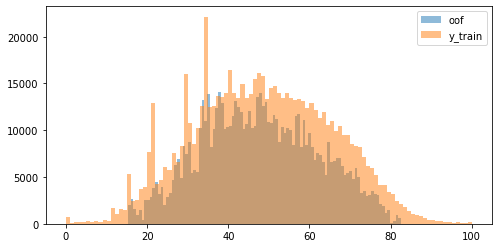

In [59]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()

In [60]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.947669960537342, 6.007693483851319, 6.261594038433911, 6.0440048959050525, 6.424300268316597]
6.1370525294088445


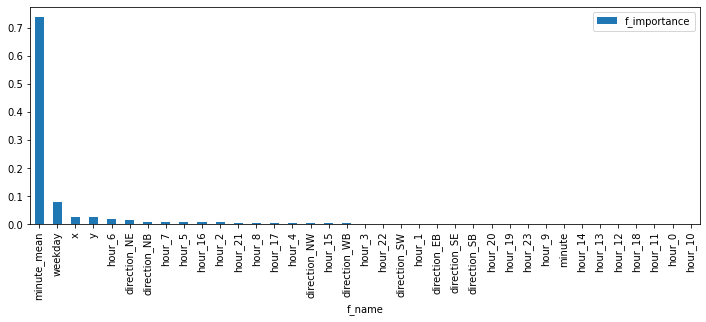

In [61]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### 018-2
018-1のminuteを削除

In [62]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [63]:
# trainとtestをまとめる
data = pd.concat([train, test])

# 時系列の特徴量を追加
data["time"] = pd.to_datetime(data["time"])
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["weekday"] = data["time"].dt.weekday

In [64]:
# 学習データ全体から座標，方角，曜日，時間，分ごとの平均値を計算
col = ["x", "y", "direction", "hour", "minute", "weekday"]
minute_mean = data.iloc[:len(train)].groupby(col).mean()
minute_mean.columns = ["minute_mean"]
data = data.merge(minute_mean, how="left", left_on=col, right_index=True)

In [65]:
# direction, hourをone-hot-encoding
data = pd.get_dummies(data, columns=["direction", "hour"])

# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [66]:
# 特徴量と目的変数に分ける
X_train = train.drop(["time", "minute", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "minute", "congestion"], axis=1)

In [67]:
direction_col = [col for col in X_train.columns if "direction" in col]
# hour_col = [col for col in X_train.columns if "hour" in col]
categorical_features = ["x", "y"] + direction_col

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                           categorical_feature=categorical_features)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.72598	valid_1's l1: 9.8088
[20]	training's l1: 7.63265	valid_1's l1: 7.71631
[30]	training's l1: 6.63285	valid_1's l1: 6.71529
[40]	training's l1: 6.18478	valid_1's l1: 6.27254
[50]	training's l1: 5.98876	valid_1's l1: 6.0841
[60]	training's l1: 5.90278	valid_1's l1: 6.00688
[70]	training's l1: 5.86108	valid_1's l1: 5.97268
[80]	training's l1: 5.83551	valid_1's l1: 5.95863
[90]	training's l1: 5.81918	valid_1's l1: 5.9518
[100]	training's l1: 5.80508	valid_1's l1: 5.94925
[110]	training's l1: 5.79353	valid_1's l1: 5.94924
Early stopping, best iteration is:
[103]	training's l1: 5.80128	valid_1's l1: 5.94905
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.76262	valid_1's l1: 9.85495
[20]	training's l1: 7.66647	valid_1's l1: 7.77539
[30]	training's l1: 6.66383	valid_1's l1: 6.77962
[40]	training's l1: 6.21787	valid_1's l1: 6.33339
[50]	training's

In [68]:
with open("../output/y_preds_018-2.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_018-2.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_018-2.pkl", "wb") as f:
    pickle.dump(oof_train, f)

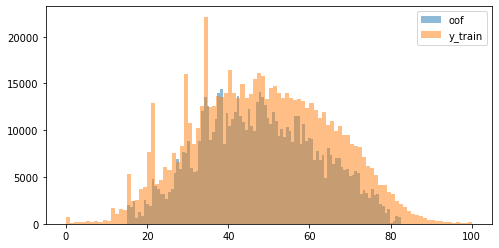

In [69]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()

In [70]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.949050512408656, 6.0074764881381775, 6.261811968005118, 6.0440776362953015, 6.424307385886577]
6.137344798146766


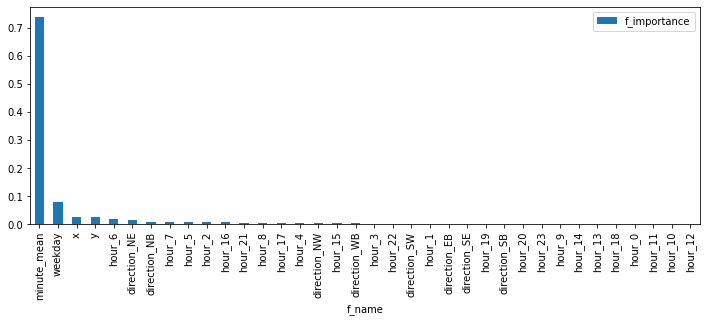

In [71]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### submit

In [72]:
with open("../output/y_preds_018-1.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_018-1.csv", index=False)


with open("../output/y_preds_018-2.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_018-2.csv", index=False)

In [73]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [74]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_018-1.csv -m "018-1"

!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_018-2.csv -m "018-2"

100% 57.5k/57.5k [00:00<00:00, 88.0kB/s]
100% 57.4k/57.4k [00:00<00:00, 89.1kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022